First lets load our data

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [2]:
# download
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

transform = transforms.ToTensor()
mnist = datasets.MNIST("../../Data",train=True,download=True,transform=transform)

celeb = datasets.CelebA("../../Data",split="train",download=True,transform=transform)


Files already downloaded and verified


In [3]:
# loading data
images = [celeb[i][0] for i in range(10000)]
labels = [celeb[i][1] for i in range(10000)]


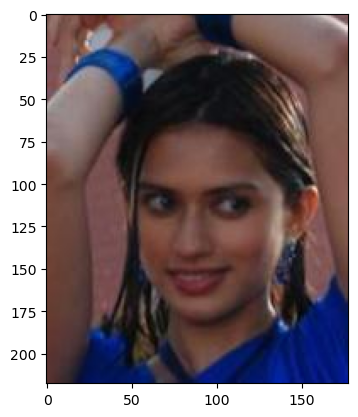

torch.Size([3, 218, 178])


In [4]:
plt.imshow(images[999].permute(1,2,0))
plt.show()
print(images[9000].shape)

## Simple Autencoder

- Lets visualize on this simple dataset the 3D latent-space of a basic (unstructured space) autoencoder

In [5]:
D1 = 218
D2 = 178 # dimensionality of data
import torch.nn as nn
# creating the MLP autoencoder
class AutoencoderMLP(nn.Module):
    def __init__(self):
        super(AutoencoderMLP, self).__init__()
        # data is N,3,1024 (B,Color,Pixels)
        # apply same transformation to each color
        # (processed as a batch dimension)
        self.encoder = nn.Sequential(
            nn.Linear(D1*D2,512), # (B,3,pixels) --> (B,3,nout)
            nn.ReLU(),
            nn.Linear(512,128), # (B,3,prev) --> (B,3,nout)
            nn.ReLU(),
            nn.Linear(128,20),
            nn.ReLU(),
            nn.Linear(20,2), # final latent-space compression
        )

        # reverse of encoder
        self.decoder = nn.Sequential(
            # doesn't need to be symetric
            # just the ability to learn a reconstruction
            nn.Linear(2,20),
            nn.ReLU(),
            nn.Linear(20,128),
            nn.ReLU(),
            nn.Linear(128,512),
            nn.ReLU(),
            nn.Linear(512,D1*D2),
            nn.Sigmoid() # values between 0 and 1
        )


    def forward(self,x):
        x = x.view(-1,3,D2*D1) # batch, 3, 32*32
        x = self.encoder(x) # bottleneck
        x = self.decoder(x) # reconstruction
        return x
    
    def get_latent(self,x):
        x = x.view(-1,D1*D2)
        x = self.encoder(x)
        return x
    
    
autoencoder = AutoencoderMLP()
# moving to GPU
device = 'cuda'
autoencoder.to(device=device)


optimizer = torch.optim.AdamW(autoencoder.parameters(),lr=3e-4,weight_decay=1e-5)

In [6]:
# to generate batches for autoencoder
def get_batch(data,size):
    # return size,3,h*w batches of data
    # data is list of tensors
    ind = torch.randint(0,len(data),size=(size,),device=device).tolist()
    batch = torch.stack([data[i] for i in ind]).to(device=device)
    return batch.view(size,3,D1*D2).to(device)

losses = []

In [7]:
# Training Loop
autoencoder.train()
for i in range(3000):
    
    # zero-grad
    optimizer.zero_grad()
    
    # forward pass
    x = get_batch(images,32)
    x_recon = autoencoder(x.clone())
    loss = nn.functional.mse_loss(x_recon,x)
    
    # stepping
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if i %100 == 0:
        print(i," loss: ",loss.item())


0  loss:  0.09272004663944244
100  loss:  0.05477098375558853
200  loss:  0.052531950175762177
300  loss:  0.04621169716119766
400  loss:  0.0408489853143692
500  loss:  0.04674476757645607
600  loss:  0.040066495537757874
700  loss:  0.04574806988239288
800  loss:  0.04603717103600502
900  loss:  0.05135171487927437
1000  loss:  0.043120790272951126
1100  loss:  0.04803913086652756
1200  loss:  0.04491402953863144
1300  loss:  0.036840394139289856
1400  loss:  0.04480750486254692
1500  loss:  0.046254318207502365
1600  loss:  0.04316011443734169
1700  loss:  0.03973596170544624
1800  loss:  0.049634769558906555
1900  loss:  0.042666807770729065
2000  loss:  0.046404656022787094
2100  loss:  0.04814879968762398
2200  loss:  0.04813351854681969
2300  loss:  0.043343327939510345
2400  loss:  0.03977067023515701
2500  loss:  0.04675440490245819
2600  loss:  0.04477831348776817
2700  loss:  0.044972777366638184
2800  loss:  0.04268989339470863
2900  loss:  0.045172110199928284


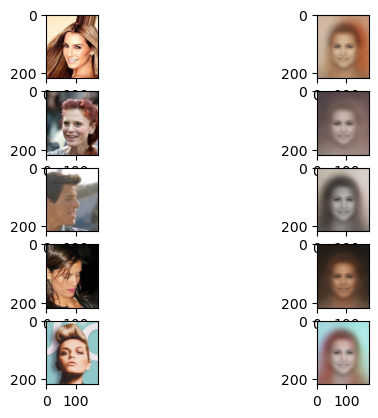

In [8]:
# Evaluating autoencoder
fig,axes = plt.subplots(5,2)


test_imgs = []

with torch.no_grad():
    for i in range(5):
        test_imgs.append(autoencoder(images[i].to(device)).to('cpu').view(3,D1,D2).permute(1,2,0))

for i in range(5):
    axes[i][0].imshow(images[i].permute(1,2,0))
    axes[i][1].imshow(test_imgs[i])

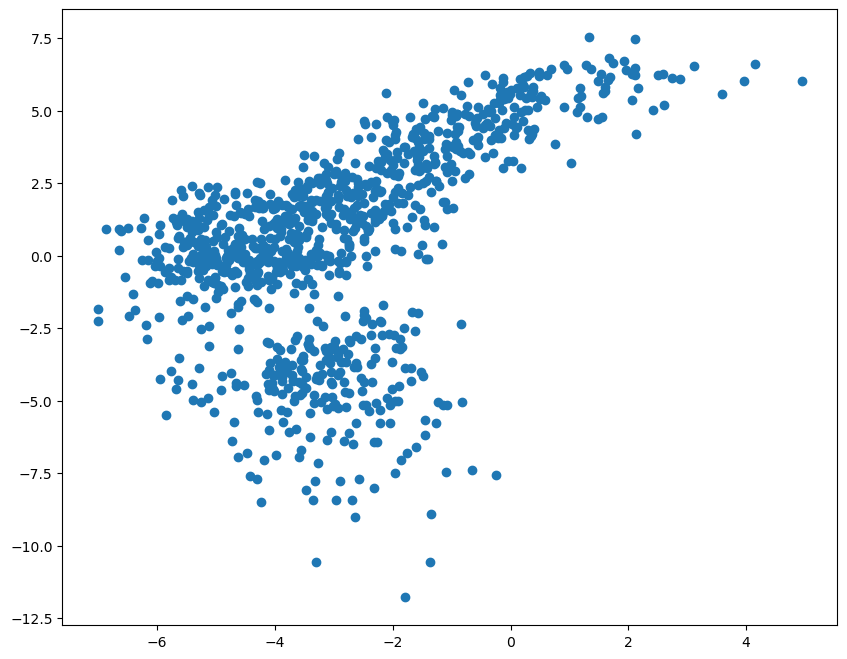

In [9]:
# Examining 3D latent-space
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

# plot color corresponding to label
latent_x = []
latent_y = []
color = []

color_map = {0:"black",
             1: 'blue',
             2:'yellow',
             3:"green",
             4:"purple",
             5:"red",
             6:"orange",
             7:"pink",
             8:"grey",
             9:"brown"}

with torch.no_grad():
    for i in range(1000):
        latents = autoencoder.get_latent(images[i].to(device)).to('cpu')[0] # 3-tensor
   
        
        # color for corresponding
        #color.append(color_map[labels[i].item()])
        
        # getting x,y,z based on latent variable
        latent_x.append(latents[0].item())
        latent_y.append(latents[1].item())
        

ax.scatter(latent_x,latent_y)

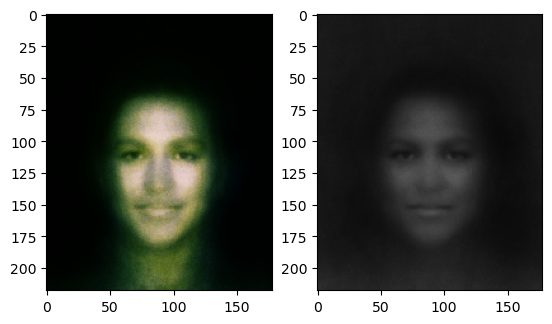

In [10]:
# trying to sample
fig,axes = plt.subplots(1,2)


test_imgs = []

# we can't sample! no center of data!
# trying to sample latent vars
show = autoencoder.decoder(torch.tensor([[10,5],[5,5],[10,-5]],dtype=torch.float32).to(device)).detach().to('cpu').view(3,D1,D2).permute(1,2,0)
show2 = autoencoder.decoder(torch.tensor([[0,0],[0,0],[0,0]],dtype=torch.float32).to(device)).detach().to('cpu').view(3,D1,D2).permute(1,2,0)

# there is no feasable way to interpret our data...

axes[0].imshow(show)
axes[1].imshow(show2)

## VAE
As we see up above, our scale is very large, and if we tried to sample from this latent-space, just as sampling from random pixels, we would have no idea what is more likely for an image, and whether shifting a latent variable will change an image in a meaningful way.

I tried playing around with sampling, but really it just causes arbitrary changes (in R,G, or B)

Having a structured latent-space allows us to actually sample, and infer about what causes what in images! Hence, our VAE motivation

> Notice the gaps in our space, these make it so we can't interpolate between points smoothly
>
> In VAE's, we also may want to, for example, to text-to-image encoding, which would not be possible if we didn't have some 'smoothing' between data

In [11]:
del autoencoder
del optimizer

In [53]:
import torch
from torch import nn
d1 = 218
d2 = 178

# D1 = 218
# D2 = 178 # original dimensionality of data

# input --> hidden --> mean,std --> sample --> decode/output
class VAE(nn.Module):
    def __init__(self,input_dim,latent_dim=20,h_dim=1000):
        super().__init__()
        self.input_dim = input_dim
        
        # encoder
        # hdim/5 in between
        self.img_2hid = nn.Linear(input_dim,h_dim)
        self.hid2 = nn.Linear(h_dim,int(h_dim/5))
        self.hid2mu = nn.Linear(int(h_dim/5),latent_dim)
        self.hid2sigma = nn.Linear(int(h_dim/5),latent_dim)
                    
        # decoder (reverse of encoder) 
        self.z_2hid = nn.Linear(latent_dim,int(h_dim/5))
        self.hid2 = nn.Linear(int(h_dim/5),h_dim)
        self.hid_2img = nn.Linear(h_dim,input_dim)
        
        
        self.relu = nn.ReLU()
        
    def encode(self,x):
        x = x.view(-1,3,self.input_dim)
        # takes in flat image
        h = self.relu(self.img_2hid(x))
        print(h.shape)
        h = self.relu(self.hid2(h))
        print(h.shape)

        
        mu = self.hid2mu(h)
        sigma = self.hid2sigma(h)
        
        return mu,sigma # sigma is std
        
        
    def decode(self,x):
        h = self.relu(self.z_2hid(x)) # potential problems?
        h = self.relu(self.hid2(h))
        h = self.hid_2img(h)
        
        return torch.sigmoid(h) # bet 0,1
    
    def forward(self,x):
        mu, sigma = self.encode(x)
        eps = torch.randn_like(mu)
        z_reparam = eps*sigma + mu
        
        x_recon = self.decode(z_reparam)
       
        
        return x_recon, mu, sigma
    
    # for visualizing latent
    def get_latent(self,x):
        mu, sigma = self.encode(x)
        eps = torch.randn_like(mu)
        z_reparam = eps*sigma + mu
        return z_reparam # 1d vector!
    

device='cpu'
autoencoderVAE = VAE(d1*d2,latent_dim=2)
autoencoderVAE.to(device)
optimizerVAE = torch.optim.AdamW(autoencoderVAE.parameters(),lr=3e-4,weight_decay=1e-5)

torch.backends.cudnn.benchmark = True

In [50]:
def get_batch(data,size):
    # return size,3,h*w batches of data
    # data is list of tensors
    ind = torch.randint(0,len(data),size=(size,)).tolist()
    batch = torch.stack([data[i] for i in ind])
    return batch.view(size,3,d1*d2).to(device)


![loss](ELBOLOSS.png)

This is our 'lower bound', or what we want to maximize to approach closer to the real probability distribution p(x) of our data

In [51]:
# Loss function for our VAE
# alpha is emphasis on mse, beta is emphasis on a normal distr.
loss_fn = nn.BCELoss(reduction="sum")
def vae_loss(x_in,x,mean,sigma,alpha=1,beta=1):
    # mean error batches --> summing for more accurate
    ############################repro_loss = ((x_in-x)**2).mean(dim=-1) 
    # mean close to 0, var close to 1
    kl = -torch.sum(torch.log(sigma.pow(2)) - sigma.pow(2) - mean.pow(2) + 1)
    # loss is mean of MSE's across batch
    # and mean of kl divergences
    # shape is B,3,Dim --> we sum across dim and then average
    repro_loss = loss_fn(x_in,x)
    
    # alpha/beta ok..
    return torch.mean(repro_loss) * alpha + torch.mean(kl) * beta




In [55]:
# Training Loop
with torch.set_grad_enabled(True):
    for i in range(30000):
        
        # forward pass
        # playing with batch shapes
        x_b = get_batch(images,32)
        out,mu,sigma  = autoencoderVAE(x_b.clone())
        loss = vae_loss(out,x_b,mu,sigma)
        
        # zero-grad
        optimizerVAE.zero_grad()
        # stepping
        loss.backward()
        optimizerVAE.step()
        losses.append(loss.item())
        
        if i %100 == 0:
            print("************************")
            print("Epoch: ",i,"complete! || loss: ",loss.item())
            print("************************")

torch.Size([32, 3, 1000])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x1000 and 200x1000)

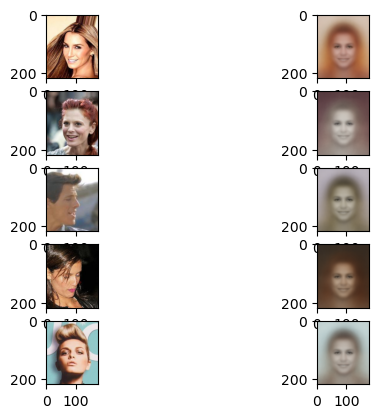

In [25]:
# Evaluating Vautoencoder
fig,axes = plt.subplots(5,2)


test_imgs = []
with torch.no_grad():
    for i in range(5):
        test_imgs.append(autoencoderVAE(images[i].to(device))[0].to('cpu').view(3,D1,D2).permute(1,2,0))

for i in range(5):
    axes[i][0].imshow(images[i].permute(1,2,0))
    axes[i][1].imshow(test_imgs[i])

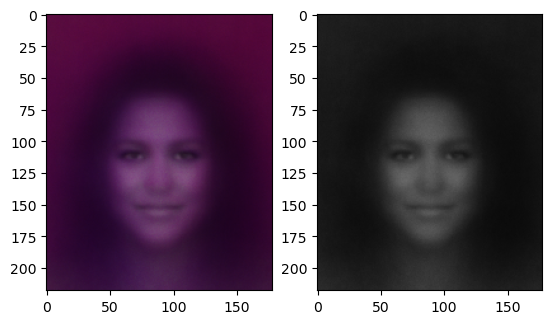

In [22]:
# sampling from new!
fig,axes = plt.subplots(1,2)


test_imgs = []


show = autoencoderVAE.decode(torch.tensor([[1,-1],[0,1],[0,-1]],dtype=torch.float32).to(device)).detach().to('cpu').view(3,d1,d2).permute(1,2,0)
show2 = autoencoderVAE.decode(torch.tensor([[0,0],[0,0],[0,0]],dtype=torch.float32).to(device)).detach().to('cpu').view(3,d1,d2).permute(1,2,0)

# there is no feasable way to interpret our data...

axes[0].imshow(show)
axes[1].imshow(show2)


tensor([[ 3.0464, -4.5139],
        [ 2.5185, -4.1106],
        [ 4.8408, -3.9069]])
tensor([[-4.5642, -0.2490],
        [-2.4753,  0.1162],
        [-1.2685,  0.4252]])
tensor([[ 0.7822, -5.2134],
        [ 0.7149, -4.3117],
        [ 1.0001, -3.6450]])
tensor([[ 0.7871, -2.9420],
        [ 3.0282, -1.6615],
        [ 2.6484, -1.0480]])
tensor([[ 1.5558, -5.3759],
        [-1.3888, -2.6886],
        [-1.8793, -2.2764]])
tensor([[-1.1435, -2.9910],
        [-0.6163, -2.4771],
        [-0.6534, -1.9645]])
tensor([[-10.8790,  -3.8863],
        [-11.8183,  -2.8716],
        [ -4.2311,  -2.1531]])
tensor([[ 2.8296, -2.1264],
        [ 3.9049, -1.5595],
        [ 3.2201, -1.2826]])
tensor([[-0.4761, -3.9946],
        [ 0.5699, -3.9309],
        [ 0.6263, -3.9883]])
tensor([[ 2.3607, -4.5437],
        [ 2.8305, -4.2014],
        [ 2.7869, -3.8527]])
tensor([[ 0.5772, -4.0979],
        [ 0.0808, -2.9345],
        [ 0.4261, -1.9601]])
tensor([[-3.9087, -2.3659],
        [-2.2581, -1.6304],
   

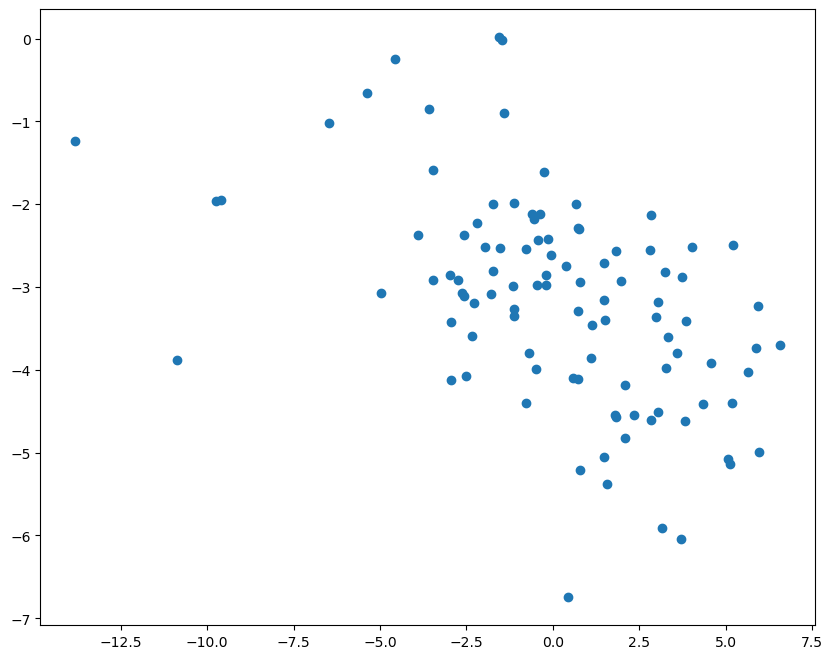

In [33]:
# Examining 3D latent-space --> copy/paste prev. code 
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

# plot color corresponding to label
latent_x = []
latent_y = []



with torch.no_grad():
    for i in range(100):
        latents = autoencoderVAE.get_latent(get_batch(images,1)).to('cpu')[0] # 3-tensor
   
        print(latents)
        # getting x,y,z based on latent variable
        latent_x.append(latents[0][0].item())
        latent_y.append(latents[0][1].item())
        

ax.scatter(latent_x,latent_y)

[Text(0, -25.0, ''), Text(0, 0.0, ''), Text(0, 25.0, ''), Text(0, 50.0, '')]

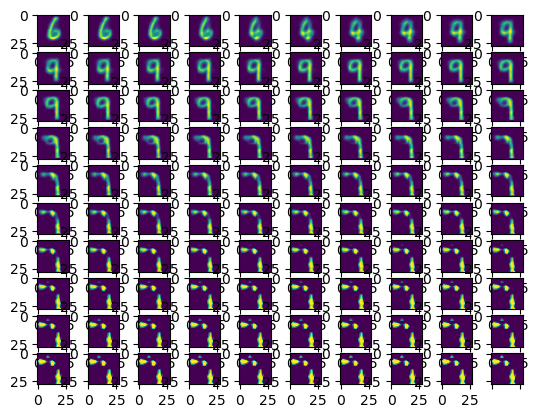

In [ ]:
test_line1 = []
for i in range(100):
    test_line1.append(autoencoderVAE.decode(torch.tensor((0+i*0.1,0,0),device=device,dtype=torch.float32)).detach().to('cpu').view(28,28))
    
fig,axs = plt.subplots(10,10)
for i in range(100):
    axs[int(i/10)][i%10].imshow(test_line1[i])
    
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
    

[Text(0, -25.0, ''), Text(0, 0.0, ''), Text(0, 25.0, ''), Text(0, 50.0, '')]

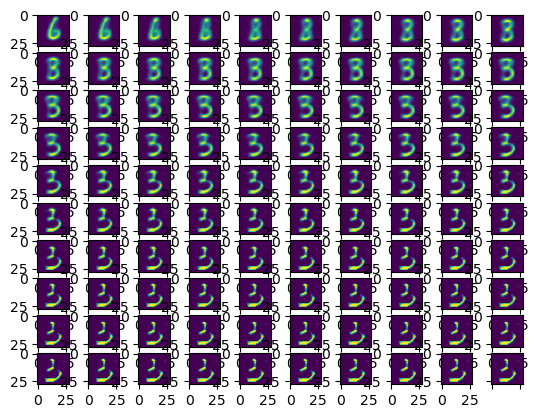

In [ ]:
test_line = []
for i in range(100):
    test_line.append(autoencoderVAE.decode(torch.tensor((0,0+i*0.1,0),device=device,dtype=torch.float32)).detach().to('cpu').view(28,28))
    
fig,axs = plt.subplots(10,10)
for i in range(100):
    axs[int(i/10)][i%10].imshow(test_line[i])

plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])

[Text(0, -25.0, ''), Text(0, 0.0, ''), Text(0, 25.0, ''), Text(0, 50.0, '')]

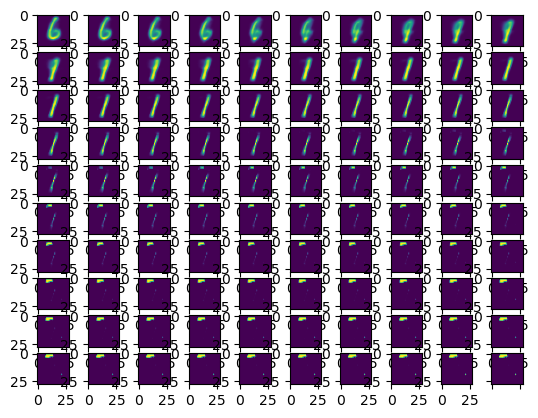

In [ ]:
test_line = []
for i in range(100):
    test_line.append(autoencoderVAE.decode(torch.tensor((0,0,0+i*0.1),device=device,dtype=torch.float32)).detach().to('cpu').view(28,28))
    
fig,axs = plt.subplots(10,10)
for i in range(100):
    axs[int(i/10)][i%10].imshow(test_line[i])
    
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])


[Text(0, -25.0, ''), Text(0, 0.0, ''), Text(0, 25.0, ''), Text(0, 50.0, '')]

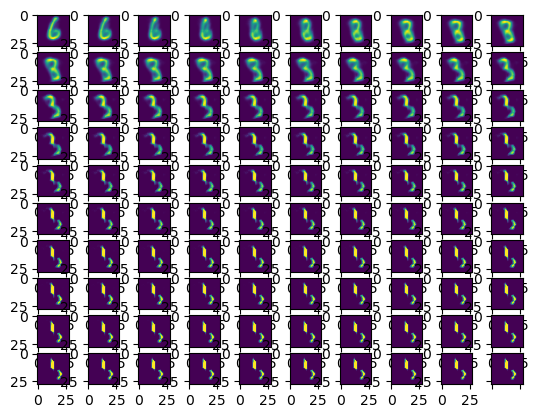

In [ ]:
test_line = []
for i in range(100):
    test_line.append(autoencoderVAE.decode(torch.tensor((i*0.1,i*0.1,i*0.1),device=device,dtype=torch.float32)).detach().to('cpu').view(28,28))
    
fig,axs = plt.subplots(10,10)
for i in range(100):
    axs[int(i/10)][i%10].imshow(test_line[i])

plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])